© 2025. Triad National Security, LLC. All rights reserved.
This program was produced under U.S. Government contract 89233218CNA000001 for Los Alamos National Laboratory (LANL), which is operated by Triad National Security, LLC for the U.S. Department of Energy/National Nuclear Security Administration. All rights in the program are reserved by Triad National Security, LLC, and the U.S. Department of Energy/National Nuclear Security Administration. The Government is granted for itself and others acting on its behalf a nonexclusive, paid-up, irrevocable worldwide license in this material to reproduce, prepare. derivative works, distribute copies to the public, perform publicly and display publicly, and to permit others to do so.


Analytic solution for 2D coupled hydromechanics Mcnamee-Gibson Problem (McNamee&Gibson, 1960a, 1960b).
McNamee J, Gibson RE (1960a) Displacement functions and linear transforms applied to diffusion through porous elastic media. Q J Mech Appl Math 13(1):98–111
McNamee J, Gibson RE (1960b) Plain strain and axially symmetric problems of the consolidation of a semi-infinite clay stratum. Q J Mech Appl Math 13(2):210–227

Two-dimensional consolidation problem and soil is fully saturated.
A constant face load is applied on the partial side of the top surface (with length a) of a sample while the roller/no-flux boundary conditions are applied to the left/right/bottom three surfaces.
Drainage is only allowed across the top surface.
Single-phase flow with incompressible water.
Plane strain (x-z system), no gravity, no source/sinks.

In [1]:
from scipy.integrate import quad
import math
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [2]:

def excess_pore_pressure_left(t, z_array, P0, L0, Cv, v):
    """ Analytic solution for pressure along the left boundary

    Parameters
    -------------------
        t : float 
            Time in seconds
        z_array : numpy array
            x values of the left boundary of the domain
        P0 : float
            Strip loading pressure (Pa)
        L0 : float
            Strip loading length 
        Cv : float 
            coefficient of consolidation 
        v  : float 
            Poisson's ratio

    Returns 
    -----------------
        pressure : numpy array
            pressure solution (along the left boundary) given the elapsed time

    Notes
    -----------------
        none
    
    """
    print("Computing pressure ")
    
    t=t/(L0**2/Cv)       # Dimensionless time
    zz=z_array/L0        # Dimensionless z-coordinate
    x=0                  # Left boundary in x-z system x equals 0
    eta = (1-v)/(1-2*v)  # Auxiliary elastic constant
    var1 = [
        eta/(2*eta -1)
        * quad(lambda ksi: 2/np.pi/ksi*np.cos(x*ksi)*np.sin(ksi)*np.exp(-ksi*z)* \
                           (1+math.erf(ksi*np.sqrt(t))+ \
                              (eta-1)/eta*np.exp((1-2*eta)*ksi**2*t/eta/eta)* \
                                 math.erfc((eta-1)/eta*ksi*np.sqrt(t)) ),
            0,
            np.inf,
            epsabs=1e-15,
            limit=1000,
        )[0]
        for z in zz
    ]

    var2 = [
        eta/(2*eta -1)
        * quad(lambda ksi: 2/np.pi/ksi*np.cos(x*ksi)*np.sin(ksi)*  \
                          (np.exp(-ksi*z)*math.erfc(z/2/np.sqrt(t)-ksi*np.sqrt(t))+ \
                            (eta-1)/eta*np.exp((1-2*eta)*ksi**2*t/eta/eta+(eta-1/eta)*ksi*z)* \
                               math.erfc((eta-1)/eta*ksi*np.sqrt(t)+z/2/np.sqrt(t)) ),
            0,
            np.inf,
            epsabs=1e-15,
            limit=1000,
        )[0]
        for z in zz
    ]    

    pressure1 = (np.array (var1) - np.array (var2))  # dimensionless pressure
    
    # converting the dimensionless pressure to dimensional pore pressure
    pressure  = pressure1*P0                         
   
    print("Computing pressure - done")
    return pressure


def displacement_top(t, x_array, P0, L0, Cv, v, G):
    """ Analytic solution for pressure along the top boundary

    -------------------
        t : float 
            Time in seconds
        x_array : numpy array
            x values of the left boundary of the domain
        P0 : float
            Strip loading pressure (Pa)
        L0 : float
            Strip loading length 
        Cv : float 
            coefficient of consolidation 
        v  : float 
            Poisson's ratio
        G  : float 
            Shear modulus
               
    Returns 
    -----------------
        displacement : numpy array
           displacement solution (along the top boundary) given the elapsed time

    Notes
    -----------------
        None 

    """
    print("\nComputing displacement")
    
    t=t/(L0**2/Cv)       # Dimensionless time
    xx=x_array/L0        # Dimensionless z-coordinate
    z=0                  # Top boundary in x-z system z equals 0
    eta = (1-v)/(1-2*v)  # Auxiliary elastic constant    
#    E=60.0E9            # Young's modulus 
#    p0=1E6              # Strip Loading Pressure (Pascals)
#    G=E0/2/(1+v)        # Shear modulus  

    var1 = [
        eta/(2*eta -1)
        * quad(lambda ksi: 1/ksi*2/np.pi/ksi*np.cos(x*ksi)*np.sin(ksi)* \
                           ( math.erf(ksi*np.sqrt(t))- \
                              (eta-1)/eta*
                                 ( 1-np.exp((1-2*eta)*ksi**2*t/eta/eta)* \
                                     math.erfc((eta-1)/eta*ksi*np.sqrt(t)) )   ),
            0,
            np.inf,
#           5000,
            epsabs=1e-5,
            epsrel=1e-5,
            limit=100000
        )[0]
        for x in xx
       ]
        
    """
    # calc initial instant displacement, but this integrand requires high precision
        var2 = [
            1/2/G
            * quad(lambda E: 1/E*2/np.pi/E*np.cos(x*E)*np.sin(E),
                0,
    #            np.inf,
                5000,
                epsabs=1e-5,
                epsrel=1e-5,
                limit=100000
            )[0]
            for x in xx
         ]    
    
    # converting the dimensionless displacement to the actual displacement 
    displacement  = ( np.array(var1)/2/G + np.array(var2) ) *p0*L0  
    """     
    
    displacement1  = np.array(var1)          # this is dimensionless 2*G*delta_u 
    displacement  = np.array(var1)/2/G*P0*L0 # this is dimensional delta_u [m]  

    print("Computing displacement - done")
    return displacement


def excess_pore_pressure_left_point(t_array, z_array, P0, L0, Cv, v):
    """ Analytic solution for pressure at specific obs points on the left boundary

    Parameters
    -------------------
        t_array : numpy array 
            Time in seconds
        z_array : float
            z values of the left boundary of the domain
        P0 : float
            Strip loading pressure (Pa)
        L0 : float
            Strip loading length 
        Cv : float 
            coefficient of consolidation 
        v  : float 
            Poisson's ratio

    Returns 
    -----------------
        pressure : numpy array
            pressure solution at specific obs points against the elapsed time

    Notes
    -----------------
        none
    
    """
    print("Computing pressure at specific points ")
    
    tt=t_array/(L0**2/Cv) # Dimensionless time
    z=z_array/L0          # Dimensionless z-coordinate, typically choosing 0.5, 1.0, or 1.5
    x=0                   # Left boundary in x-z system x equals 0
    eta = (1-v)/(1-2*v)   # Auxiliary elastic constant
    var1 = [
        eta/(2*eta -1)
        * quad(lambda ksi: 2/np.pi/ksi*np.cos(x*ksi)*np.sin(ksi)*np.exp(-ksi*z)* \
                           (1+math.erf(ksi*np.sqrt(t))+ \
                              (eta-1)/eta*np.exp((1-2*eta)*ksi**2*t/eta/eta)* \
                                 math.erfc((eta-1)/eta*ksi*np.sqrt(t)) ),
            0,
            np.inf,
            epsabs=1e-15,
            limit=1000,
        )[0]
        for t in tt
    ]

    var2 = [
        eta/(2*eta -1)
        * quad(lambda ksi: 2/np.pi/ksi*np.cos(x*ksi)*np.sin(ksi)*  \
                          (np.exp(-ksi*z)*math.erfc(z/2/np.sqrt(t)-ksi*np.sqrt(t))+ \
                            (eta-1)/eta*np.exp((1-2*eta)*ksi**2*t/eta/eta+(eta-1/eta)*ksi*z)* \
                               math.erfc((eta-1)/eta*ksi*np.sqrt(t)+z/2/np.sqrt(t)) ),
            0,
            np.inf,
            epsabs=1e-15,
            limit=1000,
        )[0]
        for t in tt
    ]    

    pressure1 = (np.array (var1) - np.array (var2))  # dimensionless pressure
    
    # converting the dimensionless pressure to dimensional pore pressure
    pressure  = pressure1*P0                         
   
    print("Computing pressure at specific points - done")
    return pressure


def displacement_top_point(t_array, x_array, P0, L0, Cv, v, G):
    """ Analytic solution for pressure at specific obs points on the top boundary

    -------------------
        t_array : numpy array
            Time in seconds
        x_array : float 
            x values of the top boundary of the domain
        p0 : float
            Strip loading pressure (Pa)
        L0 : float
            Strip loading length 
        Cv : float 
            coefficient of consolidation 
        v  : float 
            Poisson's ratio
        G  : float 
            Shear modulus
               
    Returns 
    -----------------
        displacement : numpy array
           displacement solution at specific obs points against the elapsed time

    Notes
    -----------------
        None 

    """
    print("\nComputing displacement at specific points")
    
    tt=t_array/(L0**2/Cv) # Dimensionless time
    x=x_array/L0          # Dimensionless x-coordinate, typically choosing 0.5, 1.0, or 1.5
    z=0                   # Top boundary in x-z system z equals 0
    eta = (1-v)/(1-2*v)   # Auxiliary elastic constant    
#    E=60.0E9             # Young's modulus 
#    p0=1E6               # Strip Loading Pressure (Pascals)
#    G=E0/2/(1+v)         # Shear modulus  

    var1 = [
        eta/(2*eta -1)
        * quad(lambda ksi: 1/ksi*2/np.pi/ksi*np.cos(x*ksi)*np.sin(ksi)* \
                           ( math.erf(ksi*np.sqrt(t))- \
                              (eta-1)/eta*
                                 ( 1-np.exp((1-2*eta)*ksi**2*t/eta/eta)* \
                                     math.erfc((eta-1)/eta*ksi*np.sqrt(t)) )   ),
            0,
            np.inf,
#           5000,
            epsabs=1e-5,
            epsrel=1e-5,
            limit=100000
        )[0]
        for t in tt
       ]
        
    """
    # calc initial instant displacement, but this integrand requires high precision
        var2 = [
            1/2/G
            * quad(lambda E: 1/E*2/np.pi/E*np.cos(x*E)*np.sin(E),
                0,
    #            np.inf,
                5000,
                epsabs=1e-5,
                epsrel=1e-5,
                limit=100000
            )[0]
            for t in tt
         ]    
    
    # converting the dimensionless displacement to actual displacement 
    displacement  = ( np.array(var1)/2/G + np.array(var2) ) *p0*L0  
    """      
    
    displacement1  = np.array(var1)          # this is dimensionless 2*G*delta_u 
    displacement  = np.array(var1)/2/G*P0*L0 # this is dimensional delta_u [m]  

    print("Computing displacement at specific points - done")
    return displacement

In [3]:
print("Computing solution for McName-Gibson 1960")
# Model Parameters 
P0 = 1.0e6     # Strip loading pressure (Pascals)
L0 = 1.0         # Strip loading length (meters)
k = 3.0e-14    # Matrix permeability (m^2) =50[mD] 
phi = 0.1      # Porosity 
E  = 60.0E9    # Young's modulus
v  = 0.0       # Poisson's ratio
biot  = 1.0       # Biot coefficient
Cf = 0         # Fluid compressbility
Cm = 1e-10     # Porous medium compressbility
miu = 0.001     # Dynamic viscosity
G  = E/2/(1+v) # Shear modulus    
K_c = E*(1-v) / (1+v) / (1-2*v) # Constrained modulus
# M  = 1 /( (por*Cf + (b-por)*(1-b)*Cm) ) # Biot modulus
ss = phi*Cf + (biot-phi)*(1-biot)*Cm # Specfic storage
Cv = k*K_c / miu / (K_c*ss+biot*biot) # Coefficient of consolidation 


print("\nParameters")
print("--------------------------------------")
print(f"Strip loading pressure\t\t{P0} [Pa]")
print(f"Strip loading length\t\t{L0} [m]")
print("")

#########################################################################
# calculate pressure along the left boundary at the end of the given elapsed time
# calculate displacement along the top boundary at the end of the given elapsed time
z = np.concatenate( (np.linspace(0.01, 0.1, 10), np.linspace(0.1, 1, 19), np.linspace(1, 20, 191)) )


Computing solution for McName-Gibson 1960

Parameters
--------------------------------------
Strip loading pressure		1000000.0 [Pa]
Strip loading length		1.0 [m]



In [4]:
t = 1
pressure     = excess_pore_pressure_left(t, z, P0, L0, Cv, v)
displacement = displacement_top(t, z, P0, L0, Cv, v, G)

Computing pressure 
Computing pressure - done

Computing displacement


/var/folders/w2/ykr5hgwx3rz2pb9_gljb8yx0000m0s/T/ipykernel_39632/537144627.py:113: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  * quad(lambda ksi: 1/ksi*2/np.pi/ksi*np.cos(x*ksi)*np.sin(ksi)* \


Computing displacement - done


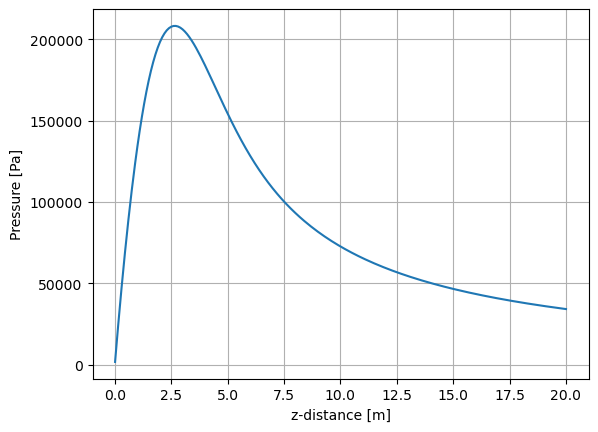

In [9]:
fig1,ax1 = plt.subplots(nrows=1)
ax1.plot(z, pressure)
ax1.set_xlabel(u'z-distance [m]')
ax1.set_ylabel(u'Pressure [Pa]') 
plt.grid(True)
plt.show()

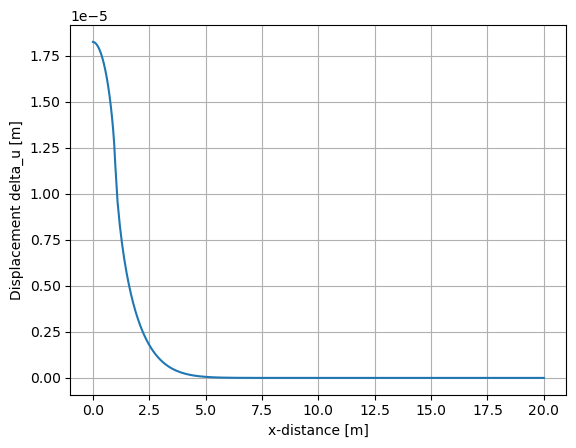

In [10]:

fig2,ax2 = plt.subplots(nrows=1)
ax2.plot(z, displacement)
ax2.set_xlabel(u'x-distance [m]')
ax2.set_ylabel(u'Displacement delta_u [m]') 
plt.grid(True)
plt.show()